# reg_part_B_NN

# Data import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import torch

In [2]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

In [3]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Artificial Neural Network for Regression

## functions

In [7]:
X = data.drop(columns=['time', "DEATH_EVENT"]).values
y = data['time'].values.reshape(-1, 1)

N, M = X.shape

input_dim  = M # M number of features
output_dim = 1 # regression problem

# X.shape, y.shape print shapes of X and y to undestand their dimensions


In [8]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X.shape, y.shape, X_test.shape, y_test.shape, print shapes of X, y, X_test and y_test to understand their dimensions after the split

In [9]:
def get_model(input_dim, hidden_dim, output_dim):
    ### BEGIN SOLUTION
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.Tanh(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
    )
    ### END SOLUTION

In [10]:
# Normalize data based on training set

def get_fold_data(X, y, train_idx, val_idx):
   
    X_train = X[train_idx]
    X_val   = X[val_idx]
    y_train = y[train_idx]
    y_val   = y[val_idx]

    mean = X_train.mean(axis=0)
    std  = X_train.std(axis=0)

    X_train_norm = (X_train - mean) / std
    X_val_norm   = (X_val   - mean) / std

    return X_train_norm, X_val_norm, y_train, y_val

# Tensor conversion

def torch_tensor_conversion(X_train, y_train, X_val, y_val):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

## code

In [ ]:
K = 10
CV = KFold(K, shuffle=True, random_state=0)
# initilize lists to store results

# Define hyperparameters
lr = 1e-3 # lr = learning rate: step size used by the optimizer when updating weights.
n_epochs = 10000 # n_epochs = number of times the entire training dataset is passed through the model during training.
momentum_list = [0.0, 0.5, 0.9]

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 4, 8, 11, 14, 20, 30, 40, 50, 100, 200]

results_plot_one = {}

for momentum_index in momentum_list:
  momentum = momentum_index
  print(f'Testing momentum: {momentum}')
  results_momentum = {}
  
  for k, (train_index, val_index) in enumerate(CV.split(X, y)):
      print(f'Fold {k+1}/{K}')

      # Get fold data using the helper function defined above get_fold_data
      X_train, X_val, y_train, y_val = get_fold_data(X, y, train_index, val_index)

      # Convert to torch tensors
      X_train, y_train, X_val, y_val = torch_tensor_conversion(X_train, y_train, X_val, y_val)

      #Set up a dictionary to store the results for each hyperparameter setting
      results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

      # Loop over the hyperparameter settings        
      for hidden_dim in hyperparameters_to_tune:
            # Define a model instance with a specific number of hidden units
            model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

            # Define loss criterion
            criterion = torch.nn.MSELoss()

            # Define the optimizer as the Adam optimizer (not needed to know the details)
            # We need to decide if we want to use gradient descent or stochastic gradient descent with batches
            # Stochastic Gradient Descent is faster for larger datasets
            # The data that we are working with is small so we can use gradient descent
            optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum= momentum) 

            for epoch in range(n_epochs):
               # Set the model to training mode
               model.train()

               # Make a forward pass through the model to compute the outputs
               outputs = model(X_train)
               # Compute the loss
               loss = criterion(outputs, y_train)

               # Make sure that the gradients are zero before you use backpropagation
               optimizer.zero_grad()
               # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
               loss.backward()
               # Update the model parameters by making the optimizer take a gradient descent step
               optimizer.step()

               # Store the training loss for this epoch in the dictionary
               results_inner[hidden_dim]['train'].append(loss.item())

               # Compute the final test loss on the test set
            with torch.no_grad(): # No need to compute gradients for the validation set
               model.eval()
               val_outputs = model(X_val)
               val_loss = criterion(val_outputs, y_val)
               results_inner[hidden_dim]['val'].append(val_loss.item())
               print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

      # Store the results for this fold
      results_momentum[k] = results_inner

  results_plot_one[momentum] = results_momentum

Testing momentum: 0.0
Fold 1/10
  Hidden units: 1, Validation set MSE: 5595.1978
  Hidden units: 2, Validation set MSE: 9128.1436
  Hidden units: 4, Validation set MSE: 8725.6650
  Hidden units: 8, Validation set MSE: 8014.3247
  Hidden units: 11, Validation set MSE: 8237.0293
  Hidden units: 14, Validation set MSE: 8221.6611
  Hidden units: 20, Validation set MSE: 6204.2915
  Hidden units: 30, Validation set MSE: 5640.1147
  Hidden units: 40, Validation set MSE: 6976.3555
  Hidden units: 50, Validation set MSE: 9903.5762
  Hidden units: 100, Validation set MSE: 8242.1592
  Hidden units: 200, Validation set MSE: 7225.8638
Fold 2/10
  Hidden units: 1, Validation set MSE: 8219.3945
  Hidden units: 2, Validation set MSE: 8872.7979
  Hidden units: 4, Validation set MSE: 9223.5537
  Hidden units: 8, Validation set MSE: 9755.6357
  Hidden units: 11, Validation set MSE: 10248.3389
  Hidden units: 14, Validation set MSE: 8951.2324
  Hidden units: 20, Validation set MSE: 11740.7109
  Hidden uni

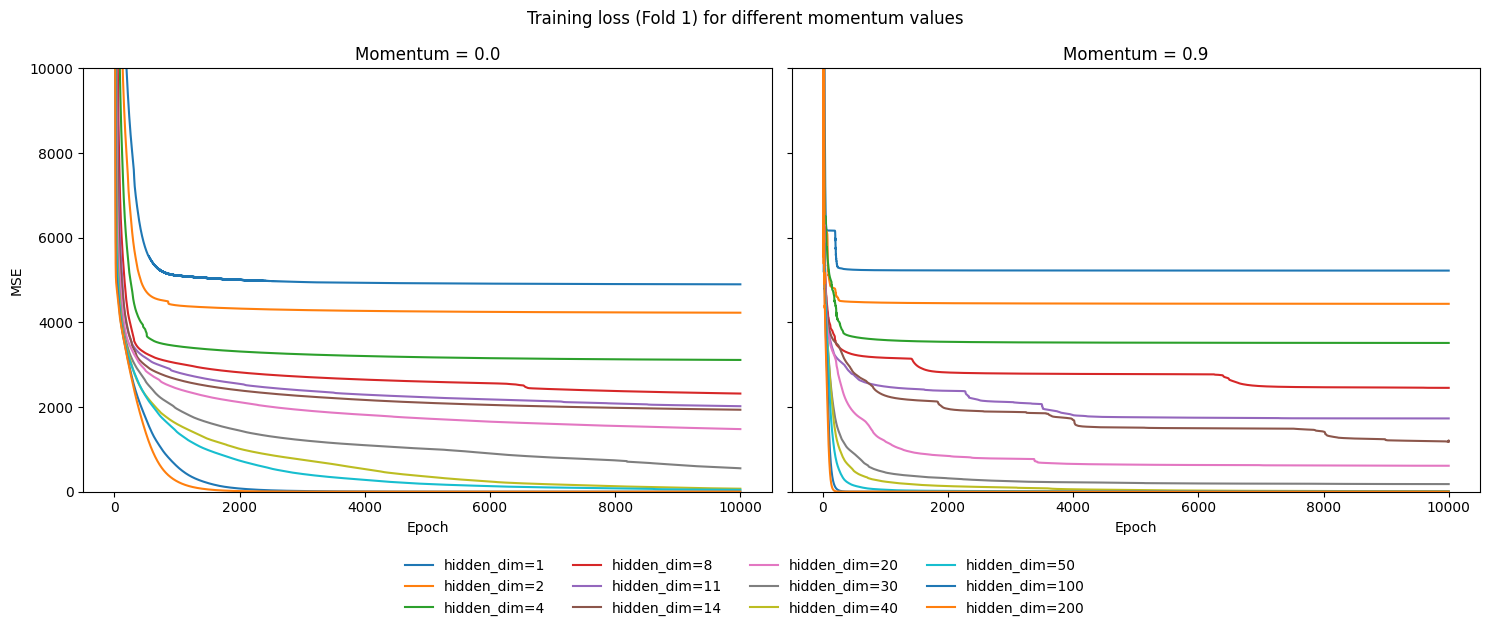

In [ ]:
"""fig, axs = plt.subplots(1, K, figsize=(12, 8), sharey=True, sharex=True)
for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        axs[fold].plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')
    axs[fold].set_title(f'Fold {fold+1}')
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('MSE')
    axs[fold].set_ylim(0, 10000)  # Set x-axis range

plt.suptitle('Training loss for different hidden units')
plt.tight_layout(rect=[0,0.15,1,1])  # Leave space at the bottom for the legend

# Place the legend at the bottom center, spanning all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=4, frameon=False)  # adjust ncol as needed for your number of labels

plt.show()
"""

momentum_list = [0.0, 0.9]
first_fold = 0
fig, axs = plt.subplots(1, len(momentum_list), figsize=(15, 6), sharey=True)

for idx, momentum in enumerate(momentum_list):
    ax = axs[idx]
    results_inner = results_plot_one[momentum][first_fold]  # first fold for this momentum
    for hidden_dim in hyperparameters_to_tune:
        ax.plot(results_inner[hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')
    ax.set_title(f'Momentum = {momentum}')
    ax.set_xlabel('Epoch')
    if idx == 0:
        ax.set_ylabel('MSE')
    ax.set_ylim(0, 10000)

plt.suptitle('Training loss (Fold 1) for different momentum values')
plt.tight_layout(rect=[0,0.08,1,1])

# Place a single legend at the bottom
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=False)

plt.show()


In [26]:
K = 10
CV = KFold(K, shuffle=True, random_state=0)
# initilize lists to store results

# Define hyperparameters
lr = 1e-3 # lr = learning rate: step size used by the optimizer when updating weights.
n_epochs_list = [100, 1000, 10000] # n_epochs = number of times the entire training dataset is passed through the model during training.
momentum_list = [0, 0.5, 0.9]

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 3, 4, 5, 8, 11, 14, 20, 30, 40, 50, 75, 100, 200]

results_plot_two = {}

for n_epochs_index in n_epochs_list:
    n_epochs = n_epochs_index

    results_epochs = {}

    for momentum_index in momentum_list:
        momentum = momentum_index
        results_momentum = {}

        for k, (train_index, val_index) in enumerate(CV.split(X, y)):
            print(f'Fold {k+1}/{K}')

            # Get fold data using the helper function defined above get_fold_data
            X_train, X_val, y_train, y_val = get_fold_data(X, y, train_index, val_index)

            # Convert to torch tensors
            X_train, y_train, X_val, y_val = torch_tensor_conversion(X_train, y_train, X_val, y_val)

            #Set up a dictionary to store the results for each hyperparameter setting
            results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

            # Loop over the hyperparameter settings        
            for hidden_dim in hyperparameters_to_tune:
                # Define a model instance with a specific number of hidden units
                model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

                # Define loss criterion
                criterion = torch.nn.MSELoss()

                # Define the optimizer as the Adam optimizer (not needed to know the details)
                # We need to decide if we want to use gradient descent or stochastic gradient descent with batches
                # Stochastic Gradient Descent is faster for larger datasets
                # The data that we are working with is small so we can use gradient descent
                optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum= momentum) 

                for epoch in range(n_epochs):
                    # Set the model to training mode
                    model.train()

                    # Make a forward pass through the model to compute the outputs
                    outputs = model(X_train)
                    # Compute the loss
                    loss = criterion(outputs, y_train)

                    # Make sure that the gradients are zero before you use backpropagation
                    optimizer.zero_grad()
                    # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
                    loss.backward()
                    # Update the model parameters by making the optimizer take a gradient descent step
                    optimizer.step()

                    # Store the training loss for this epoch in the dictionary
                    results_inner[hidden_dim]['train'].append(loss.item())

                    # Compute the final test loss on the test set
                with torch.no_grad(): # No need to compute gradients for the validation set
                    model.eval()
                    val_outputs = model(X_val)
                    val_loss = criterion(val_outputs, y_val)
                    results_inner[hidden_dim]['val'].append(val_loss.item())
                    print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

            # Store the results for this fold
            results_momentum[k] = results_inner

        results_epochs[momentum] = results_momentum

    results_plot_two[n_epochs] = results_epochs

Fold 1/10
  Hidden units: 1, Validation set MSE: 11318.2305
  Hidden units: 2, Validation set MSE: 8942.6553
  Hidden units: 3, Validation set MSE: 7805.1616
  Hidden units: 4, Validation set MSE: 6974.9780
  Hidden units: 5, Validation set MSE: 6228.4907
  Hidden units: 8, Validation set MSE: 5959.2539
  Hidden units: 11, Validation set MSE: 5976.8691
  Hidden units: 14, Validation set MSE: 6059.7852
  Hidden units: 20, Validation set MSE: 6010.6499
  Hidden units: 30, Validation set MSE: 6051.4663
  Hidden units: 40, Validation set MSE: 5975.7808
  Hidden units: 50, Validation set MSE: 5988.3813
  Hidden units: 75, Validation set MSE: 5827.0435
  Hidden units: 100, Validation set MSE: 5878.6909
  Hidden units: 200, Validation set MSE: 5761.5703
Fold 2/10
  Hidden units: 1, Validation set MSE: 22253.3613
  Hidden units: 2, Validation set MSE: 19180.9160
  Hidden units: 3, Validation set MSE: 16604.9570
  Hidden units: 4, Validation set MSE: 14837.4736
  Hidden units: 5, Validation set

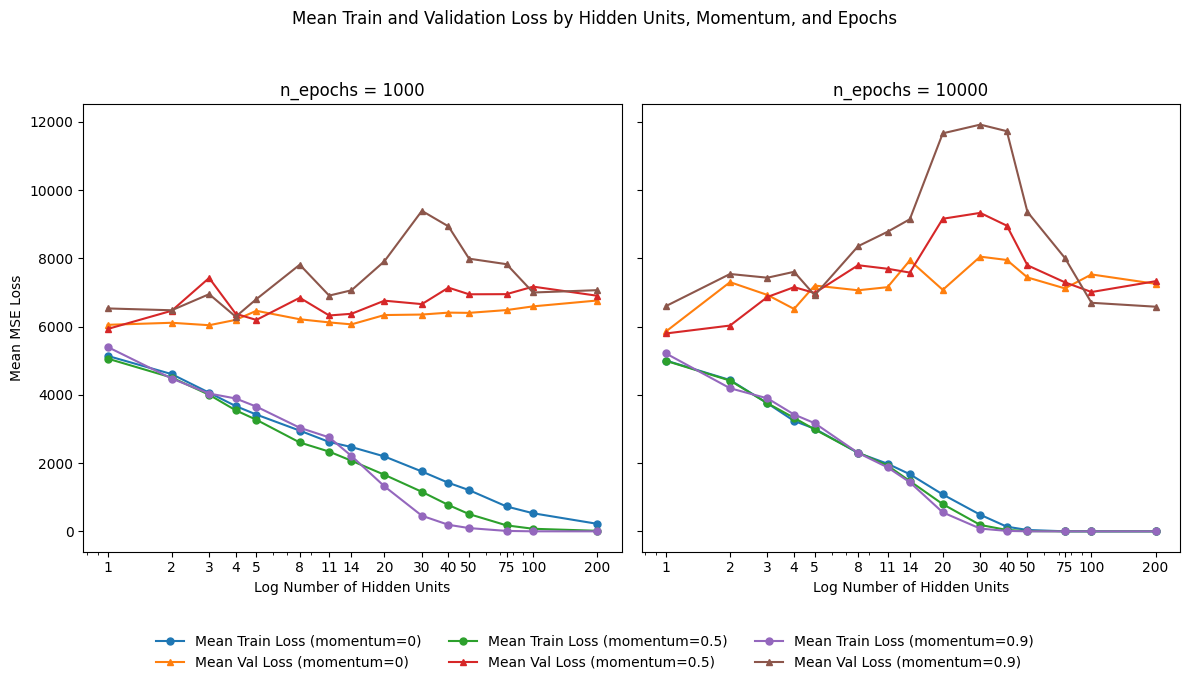

In [31]:
import matplotlib.pyplot as plt

n_epochs_list = [1000, 10000]

n_cols = len(n_epochs_list)
fig, axs = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)

for idx, n_epochs in enumerate(n_epochs_list):
    ax = axs[idx]
    results_epochs = results_plot_two[n_epochs]

    for momentum in momentum_list:
        results_momentum = results_epochs[momentum]
        hidden_units = list(results_momentum[0].keys())
        
        mean_train_loss = []
        mean_val_loss = []
        for hidden_dim in hidden_units:
            train_values = []
            val_values = []
            for k in results_momentum.keys():
                train_values.append(results_momentum[k][hidden_dim]['train'][-1])
                val_values.append(results_momentum[k][hidden_dim]['val'][-1])
            mean_train_loss.append(np.mean(train_values))
            mean_val_loss.append(np.mean(val_values))

        # Plot both mean train and val loss for each momentum
        ax.plot(hidden_units, mean_train_loss, marker='o', label=f'Mean Train Loss (momentum={momentum})', markersize=5)
        ax.plot(hidden_units, mean_val_loss, marker='^', label=f'Mean Val Loss (momentum={momentum})', markersize=5)

    ax.set_title(f'n_epochs = {n_epochs}')
    ax.set_xlabel('Log Number of Hidden Units')
    if idx == 0:
        ax.set_ylabel('Mean MSE Loss')
    ax.set_xscale('log')
    ax.set_xticks(hidden_units)
    ax.set_xticklabels([str(h) for h in hidden_units])

plt.suptitle('Mean Train and Validation Loss by Hidden Units, Momentum, and Epochs', y=1.04)
plt.tight_layout(rect=[0, 0.04, 1, 1])

# Place the legend at the bottom for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=False)

plt.show()
